In [1]:
import sys
sys.path.append('/home/potzschf/repos/')
from helperToolz.helpsters import *
from helperToolz.dicts_and_lists import *
from helperToolz.guzinski import * 
from helperToolz.mirmazloumi import *
import numpy as np
from osgeo import gdal, osr
from datetime import datetime, timezone
import re
import pandas as pd
import pvlib
from pvlib import solarposition
from pvlib.irradiance import get_total_irradiance
from pvlib.location import Location
from scipy.interpolate import NearestNDInterpolator


In [2]:
# set the year, month and day to estimate evapotranspiration for
from re import T


year = 2019
month = 'July'
day = 19
comp = 'maxLST'
sharp = 'allpred'

# set output path
tempOut = '/data/Aldhani/eoagritwin/et/Auxiliary/trash/'

# set the parameters from sharpener
mvwin = 15
cv = 0
regrat = 25
s2_masked = True
lst_masked = True

if s2_masked:
    s2Mask = 'S2Masked'
else:
    s2Mask = 'S2notMasked'

if lst_masked:
    lstMask = 'withLSTmask'
else:
    lstMask = 'withoutLSTmask'

# path to era5 raw data
era5_path = '/data/Aldhani/eoagritwin/et/Auxiliary/ERA5/grib/'
ssrd_mean_path = '/data/Aldhani/eoagritwin/et/Auxiliary/ERA5/ssrd_mean_calc/'

# path_base to sharpenend folder and S2_comp

sharp_pathbase = f'/data/Aldhani/eoagritwin/et/Sentinel3/LST/LST_values/sharpened3/{sharp}/bccec09fdbc7a94b5e2bd6c125d9d1174c2509360a2ce529f48e3512655454b5/{comp}/{year}/{month}/{day:02d}/{lstMask}/{s2Mask}/Values/'
s2_pathbase = f'/data/Aldhani/eoagritwin/et/Sentinel3/LST/LST_values/tempDump3/bccec09fdbc7a94b5e2bd6c125d9d1174c2509360a2ce529f48e3512655454b5/'
# sharp_pathbase = f'/data/Aldhani/eoagritwin/et/Sentinel3/LST/LST_values/sharpened2/{sharp}/ff3f2c872c08977466e5a8dc306d2d2aabc77ad995b0716c30d1c57d0004ebfd/{comp}/{year}/{month}/{day:02d}/{lstMask}/{s2Mask}/Values/'
# s2_pathbase = f'/data/Aldhani/eoagritwin/et/Sentinel3/LST/LST_values/tempDump2/ff3f2c872c08977466e5a8dc306d2d2aabc77ad995b0716c30d1c57d0004ebfd/'

# the LST acquisition time should determine which sharpened LST files are associatedto be processed (as they are associated with it)
LST_acq_file = f'/data/Aldhani/eoagritwin/et/Sentinel3/LST/LST_values/Acq_time/int_format/{year}/Daily_AcqTime_{comp}_{year}_{month}.tif' # epsg 4326

# the VZA at the time of LST acquisition is need
VZA_at_acq_file = f'/data/Aldhani/eoagritwin/et/Sentinel3/VZA/comp/{comp}/{year}/Daily_VZA_{comp}_{year}_{month}.tif' # epsg 4326

# the DEM, SLOPE, ASPECT, LAT, LON will be used to sharpen some of the era5 variables (the the resolution of the DEM)
dem_path = '/data/Aldhani/eoagritwin/et/Auxiliary/DEM/reprojected/DEM_GER_FORCE_WARP.tif' # epsg 4326
slope_path = '/data/Aldhani/eoagritwin/et/Auxiliary/DEM/reprojected/SLOPE_GER_FORCE_WARP.tif' # epsg 4326
aspect_path = '/data/Aldhani/eoagritwin/et/Auxiliary/DEM/reprojected/ASPECT_GER_FORCE_WARP.tif' # epsg 4326
lat_path = '/data/Aldhani/eoagritwin/et/Auxiliary/DEM/reprojected/LAT_GER_FORCE_WARP.tif' # epsg 4326
lon_path = '/data/Aldhani/eoagritwin/et/Auxiliary/DEM/reprojected/LON_GER_FORCE_WARP.tif' # epsg 4326

# the geopotential is needed for the sharpening as well
geopot_path = '/data/Aldhani/eoagritwin/et/Auxiliary/ERA5/tiff/low_res/geopotential/geopotential_low_res.tif' # epsg 4326

# sharpened LST
LST_file = f'{sharp_pathbase}{comp}_{year}_{month}_{day:02d}_mvwin{mvwin}_cv{cv}_regrat{regrat}_{s2Mask}_{lstMask}.tif' # epsg:3035

# for NDVI calculation (estimating LAI and others) and warping to S2 resolution, we use the S2 composite used for sharpening
# S2_file = [file for file in getFilelist(s2_pathbase, 'vrt', deep=False) if f'HIGHRES_{comp}_{year}_{month}_{day:02d}' in file][0]
S2_file = [file for file in getFilelist(s2_pathbase, 'vrt', deep=True) if 'S2' in file][0]

# find era5 file that matches the month of LST observation
valid_variables = sorted(list(dict.fromkeys(file.split('/')[-2] for file in getFilelist(era5_path, '.grib', deep=True) \
                                   if not any(var in file for var in ['geopotential', 'total_column_water_vapour']))))

# get a list for those era5 files that match the year and month of the provided LST acquisition file
era5_path_list = find_grib_file(getFilelist(era5_path, '.grib', deep=True), LST_acq_file)
era5_path_list = [path for path in era5_path_list if any(variable in path for variable in valid_variables)] # era5 are epsg 4326 and still will be after warping to doy
temp_pressure_checker(era5_path_list)

temperature will be processed before surface pressure - continue


In [3]:
# warp datasets needed for calculations to the spatial extent of the sharpened LST
LST_acq_spatial_sub = warp_raster_to_reference(source_path=LST_acq_file, reference_path=S2_file, output_path='MEM', resampling='near')
VZA_at_acq_file_sub = warp_raster_to_reference(source_path=VZA_at_acq_file, reference_path=S2_file, output_path='MEM', resampling='near')
dem_sub = warp_raster_to_reference(source_path=dem_path, reference_path=S2_file, output_path='MEM', resampling='bilinear')
slope_sub  = warp_raster_to_reference(source_path=slope_path, reference_path=S2_file, output_path='MEM', resampling='bilinear')
aspect_sub = warp_raster_to_reference(source_path=aspect_path, reference_path=S2_file, output_path='MEM', resampling='bilinear')
lat_sub = warp_raster_to_reference(source_path=lat_path, reference_path=S2_file, output_path='MEM', resampling='bilinear')
lon_sub = warp_raster_to_reference(source_path=lon_path, reference_path=S2_file, output_path='MEM', resampling='bilinear')
geopot_sub = warp_raster_to_reference(source_path=geopot_path, reference_path=S2_file, output_path='MEM', resampling='bilinear')

/data/Aldhani/users/potzschf/conda/envs/cds_era5/lib/python3.12/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [5]:
path_to_ssrdsc_grib = era5_path_list[-1]
reference_path = LST_acq_spatial_sub
lst_acq_file = LST_acq_spatial_sub
doy = day
slope_path = slope_sub
aspect_path = aspect_sub
dem_path = dem_sub
lat_path = lat_sub
lon_path = lon_sub

outPath='MEM'
bandL='ALL'
nodat =None
   

era_ds = warp_ERA5_to_reference(grib_path=path_to_ssrdsc_grib, reference_path=reference_path, output_path=outPath, NoData=nodat)


bandNumber = era_ds.RasterCount
era_time = [pd.Timestamp(era_ds.GetRasterBand(i+1).GetDescription()) for i in range(bandNumber)]

# open and load the acquisition raster from LST
LST_acq_ds = checkPath(lst_acq_file)
arr = LST_acq_ds.GetRasterBand(doy).ReadAsArray()
arr = arr.astype(np.int64)
arr_flat = arr.ravel()
arr_ts = pd.to_datetime(arr_flat, unit='s')
arr_up = pd.Series(arr_ts).dt.ceil('h')
arr_up = arr_up.values.reshape(arr.shape)
arr_min = pd.Series(arr_ts).dt.minute
arr_min = arr_min.values.reshape(arr.shape)

# get the relevant bands of era5 dataset (i.e. those bands, that reflect the upper and lower )
bands = []
for d1 in np.unique(arr_up):
    for count, e5 in enumerate(era_time):
        if d1 == e5:
            bands.append(count)
# load the era5 variable acquisition-wise into 2D numpy array 
# load the era5 variable acquisition-wise into 2D numpy array 
arrL = []
for b in bands: 
    # compare the time of LST composite with 
    mask = arr_up == era_time[b]
    # load the band that holds the observation just after LST acquisition
    after = era_ds.GetRasterBand(b).ReadAsArray()
    # load the band that holds the observation just prior to LST acquisition
    before = era_ds.GetRasterBand(b-1).ReadAsArray()
    # calculate the linearly interpolated values at the minute of acquisition
    vals_interpolated = before - (before - after) * (np.array(arr_min, dtype=np.float16) / 60) # in J/m²
    # convert to W/m²
    vals_watt = vals_interpolated /3600
    arrL.append(vals_watt * mask)
block = np.dstack(arrL)

block[block == 0] = np.nan
ssrd_watt = np.nanmax(block, axis = 2)

# make a mask of the nan values, as the output of pvlib.irradiance.get_total_irradiance does skip them which hinders rebuild to 2D
valid_mask = np.isfinite(ssrd_watt)
arr_ts_masked = arr_ts[valid_mask.ravel()]

# load slope, aspect, lat, lon, dem
ds = checkPath(slope_path)
slope = ds.GetRasterBand(1).ReadAsArray()
slope_flat = slope.ravel()
slope_flat_masked = slope_flat[valid_mask.ravel()]

ds = checkPath(aspect_path)
aspect = ds.GetRasterBand(1).ReadAsArray()
aspect_flat = aspect.ravel()
aspect_flat_masked = aspect_flat[valid_mask.ravel()]

ds = checkPath(dem_path)
dem = ds.GetRasterBand(1).ReadAsArray()
dem_flat = dem.ravel()
dem_flat_masked = dem_flat[valid_mask.ravel()]

ds = checkPath(lat_path)
lat = ds.GetRasterBand(1).ReadAsArray()
lat_flat = lat.ravel()
lat_flat_masked = lat_flat[valid_mask.ravel()]

ds = checkPath(lon_path)
lon = ds.GetRasterBand(1).ReadAsArray()
lon_flat = lon.ravel()
lon_flat_masked = lon_flat[valid_mask.ravel()]

# get solar viewing conditions for acquisition time
site = Location(lat_flat_masked, lon_flat_masked, altitude=dem_flat_masked, tz='UTC')
solpos = site.get_solarposition(arr_ts_masked)

# calculate extraterrestrial radiation (horizontal)
dni_extra = pvlib.irradiance.get_extra_radiation(arr_ts_masked)

# Compute clearness index
ssrd_watt_flat = ssrd_watt.ravel()
ssrd_watt_flat_masked = ssrd_watt_flat[valid_mask.ravel()]
ghi = ssrd_watt_flat_masked
cos_zenith = np.cos(np.radians(solpos['zenith'].values[0]))
ghi_clear = dni_extra.values[0] * cos_zenith
kt = ghi / ghi_clear

# Decompose GHI to DNI and DHI using Erbs model
dni, dhi = pvlib.irradiance.erbs(ghi, solpos['zenith'], arr_ts_masked)['dni'], \
        pvlib.irradiance.erbs(ghi, solpos['zenith'], arr_ts_masked)['dhi']

# compute radiation on the tilted terrain

irradiance_tilted = get_total_irradiance(
    surface_tilt=slope_flat_masked,
    surface_azimuth=aspect_flat_masked,
    dni=dni,
    ghi=ghi,
    dhi=dhi,
    solar_zenith=solpos['zenith'],
    solar_azimuth=solpos['azimuth']
)


# bring back to 2D
poa_global_arr = np.full(slope.shape, np.nan)
poa_global_arr[valid_mask] = irradiance_tilted['poa_global']


zenith_arr = np.full(slope.shape, np.nan)
zenith_arr[valid_mask] = solpos['zenith'].to_numpy()

azimuth_arr = np.full(slope.shape, np.nan)
azimuth_arr[valid_mask] = solpos['azimuth'].to_numpy()

# calculate also the daily ssrd mean 
meanL = []
for count, e5 in enumerate(era_time):
    if e5.day == doy:
        ssrd_hour = era_ds.GetRasterBand(count).ReadAsArray()
        if np.sum(ssrd_hour) == 0:
            continue
        else:
            time_hour = np.full((len(lat_flat_masked),), e5)
            # get solar viewing conditions for acquisition time
            
            solpos = solarposition.get_solarposition(
                time=time_hour,       # vector of timestamps
                latitude=lat_flat_masked, # vector of latitudes (same length as time or broadcastable)
                longitude=lon_flat_masked,
                altitude=dem_flat_masked
            )

                        # Compute clearness index
            ghi = ssrd_hour / 3600
            ghi_masked = ghi[valid_mask]
            # Decompose GHI to DNI and DHI using Erbs model
            dni_dhi = pvlib.irradiance.erbs(ghi_masked.ravel(), solpos['zenith'], e5)
            dni, dhi = dni_dhi['dni'], dni_dhi['dhi']

            # compute radiation on the tilted terrain
            irradiance_tilted = get_total_irradiance(
            surface_tilt=slope_flat_masked,
            surface_azimuth=aspect_flat_masked,
            dni=dni,
            ghi=ghi_masked.ravel(),
            dhi=dhi,
            solar_zenith=solpos['zenith'],
            solar_azimuth=solpos['azimuth']
            )

            # put back into raster shape
            irr_2D = np.full(slope.shape, np.nan)
            irr_2D[valid_mask] = irradiance_tilted['poa_global']
            meanL.append(irr_2D)

/tmp/ipykernel_2383201/101517954.py:57: RuntimeWarning: All-NaN slice encountered
  ssrd_watt = np.nanmax(block, axis = 2)


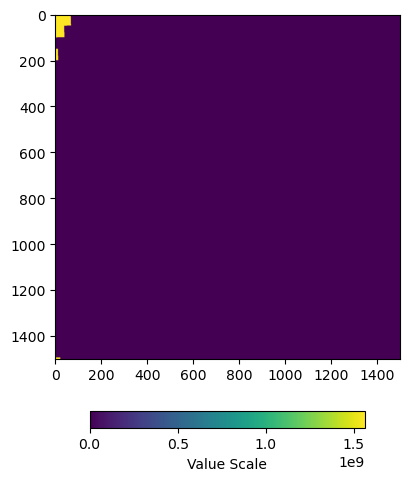

In [7]:


plotter(arr)


/tmp/ipykernel_2383201/4120794974.py:2: RuntimeWarning: Mean of empty slice
  bb = np.nanmean(np.dstack(meanL), axis = 2)


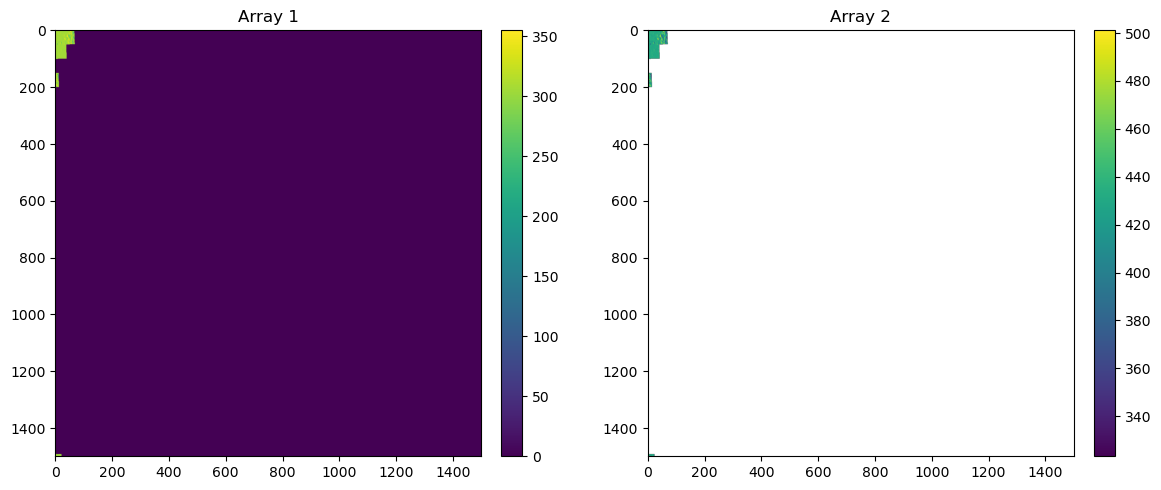

In [16]:
aa = np.nansum(np.dstack(meanL), axis=2) / 24
bb = np.nanmean(np.dstack(meanL), axis = 2)

plotter_side_by_side(aa,bb)


In [ ]:
ssrd_mean = np.nansum(np.dstack(meanL), axis=2) / 24 # np.nanmean(np.dstack(meanL), axis = 2)
ssrd_mean = ssrd_mean.reshape(slope.shape)

In [15]:
aa

array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [309.7614143 , 312.26089882, 310.60927122, ...,          nan,
                 nan,          nan],
       ...,
       [309.93856265, 309.52197677, 308.3805522 , ...,          nan,
                 nan,          nan],
       [309.61397562, 308.42784911, 306.67310483, ...,          nan,
                 nan,          nan],
       [308.35979251, 307.86897089, 306.03430301, ...,          nan,
                 nan,          nan]], shape=(1500, 1500))